In [1]:
import logging; logging.basicConfig(level=logging.DEBUG)
from __future__ import absolute_import, unicode_literals, print_function

import dropbot as db
import pandas as pd

In [2]:
try:
    proxy.terminate()
except NameError:
    pass

proxy = db.SerialProxy(ignore=True)
signal = proxy.signals.signal('capacitance-updated')

proxy.update_state(hv_output_selected=True, hv_output_enabled=True, voltage=100, frequency=10e3)
proxy.state

DEBUG:trollius:Using selector: SelectSelector
DEBUG:base_node_rpc.async:`ProactorEventLoop` required, not `<class 'trollius.windows_events._WindowsSelectorEventLoop'>`loop in background thread.
DEBUG:base_node_rpc.async:Execute new loop in background thread.
DEBUG:trollius:Using proactor: IocpProactor
DEBUG:base_node_rpc.async:`ProactorEventLoop` required, not `<class 'trollius.windows_events._WindowsSelectorEventLoop'>`loop in background thread.
DEBUG:base_node_rpc.async:Execute new loop in background thread.
DEBUG:trollius:Using proactor: IocpProactor
DEBUG:base_node_rpc.proxy:Attempt to connect to device on port COM8 (baudrate=115200)
DEBUG:serial_device.threaded:Open `COM8` and monitor connection status
DEBUG:serial_device.threaded:connection_made: `COM8` `<ReaderThread(Thread-17, started daemon 8984)>`
DEBUG:base_node_rpc.proxy:Wait for connection to port COM8
INFO:base_node_rpc.proxy:Successfully connected to dropbot on port COM8


hv_output_selected                 True
hv_output_enabled                  True
channel_count                         0
frequency                         10000
voltage                             100
target_capacitance                    0
capacitance_update_interval_ms        0
dtype: object

In [3]:
N = proxy.number_of_channels

In [5]:
class Plot:
    def __init__(self, *args, **kwargs):
        self._args = args
        self._kwargs = kwargs
    
    def display(self):
        fig = plt.figure(*self._args, **self._kwargs)
        ax = fig.add_subplot(111)
        self.ax = ax
        ax.patch.set_alpha(0.1)
        plt.ion()

        fig.show()
        fig.canvas.draw()

        self.line = ax.plot([], [])[0]
        siC_formatter = FuncFormatter(lambda x, *args: si.si_format(x) + 'F')
        ax.yaxis.set_major_formatter(siC_formatter)
        return ax

    def update(self, data_series):
        self.line.set_data((data_series.index,
                            data_series.values))
        self.ax.relim()
        self.ax.autoscale()
        fig = self.ax.get_figure()
        fig.canvas.draw()
        fig.tight_layout()

In [6]:
class DataLogger:
    def __init__(self, n, value_key, index_key):
        self.values = []
        self.index = []
        self.value_key = value_key
        self.index_key = index_key
        self.n = n

    def save(self, event):
        self.values.append(event.get(self.value_key))
        self.index.append(event.get(self.index_key))

        for array in (self.values, self.index):
            if len(array) > self.n:
                array.pop(0)
                
    def to_series(self):
        return pd.Series(self.values, index=self.index)

In [7]:
%matplotlib notebook
from __future__ import absolute_import, print_function, unicode_literals

from matplotlib.ticker import FuncFormatter
import functools as ft
import ipywidgets
import matplotlib.pyplot as plt
import numpy as np
import si_prefix as si

import threading


class PlotController:
    def __init__(self, proxy, n, refresh_interval=.25, update_interval=None):
        self.plot_stop = threading.Event()
        self.refresh_stopped = threading.Event()
        self.plot = Plot()
        self.data_logger = DataLogger(n=n, value_key='new_value', index_key='end')
        self.proxy = proxy
        self.proxy.signals.signal('capacitance-updated').connect(self.data_logger.save)
        self._refresh_interval = refresh_interval
        if update_interval is None:
            self._update_interval = refresh_interval
        else:
            self._update_interval = update_interval
        
    @property
    def update_interval(self):
        return self._update_interval
    
    @update_interval.setter
    def update_interval(self, value):
        self._update_interval = value
        self.stop()
        self.start()
    
    @property
    def refresh_interval(self):
        return self._refresh_interval
    
    @refresh_interval.setter
    def refresh_interval(self, value):
        self._refresh_interval = value
        self.stop()
        self.start()
    
    def display(self):
        self.start_button = ipywidgets.Button(description='Start')
        self.stop_button = ipywidgets.Button(description='Stop')

        N = int(proxy.number_of_channels)
        self.channels = [ipywidgets.SelectMultiple(options=range(40 * i, 40 * (i + 1))[:N], rows=40)
                         for i in range(int(np.ceil(N / 40.)))]
        for channels_i in self.channels:
            channels_i.observe(self.actuate_selected, names=['value'], type='change')

        self.stop_button.disabled = True
        self.start_button.on_click(self.start)
        self.stop_button.on_click(self.stop)
        self.widgets = ipywidgets.HBox([self.start_button, self.stop_button] + self.channels)
        return self.plot.display(), self.widgets
        
    def actuate_selected(self, event):
        state_of_channels = proxy.state_of_channels
        state_of_channels[list(event['owner'].options)] = 0
        state_of_channels[list(event['new'])] = 1
        proxy.state_of_channels = state_of_channels

    def start(self, *args):
        self.plot_stop.clear()
        self.refresh_stopped.clear()

        proxy.update_state(capacitance_update_interval_ms=int(self.update_interval * 1e3))
        self.start_button.disabled = True
        self.stop_button.disabled = False
        
        def _refresh_plot(refresh_interval):
            while not self.plot_stop.wait(refresh_interval):
                self.plot.update(self.data_logger.to_series())
            self.refresh_stopped.set()

        self.thread = threading.Thread(target=_refresh_plot, args=(self.refresh_interval, ))
        self.thread.daemon = True
        self.thread.start()

    def stop(self, *args):
        self.plot_stop.set()
        self.refresh_stopped.wait(5)
        
        self.proxy.update_state(capacitance_update_interval_ms=0)
        self.start_button.disabled = False
        self.stop_button.disabled = True

<IPython.core.display.Javascript object>


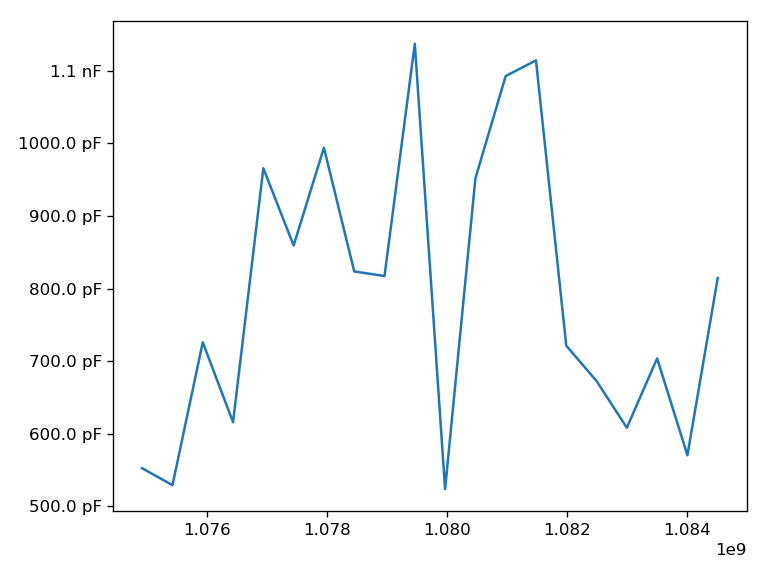

HBox(children=(Button(description=u'Start', style=ButtonStyle()), Button(description=u'Stop', disabled=True, style=ButtonStyle())))

In [8]:
controller = PlotController(proxy, 100, update_interval=.5)
fig, controls = controller.display()
controls

<IPython.core.display.Javascript object>


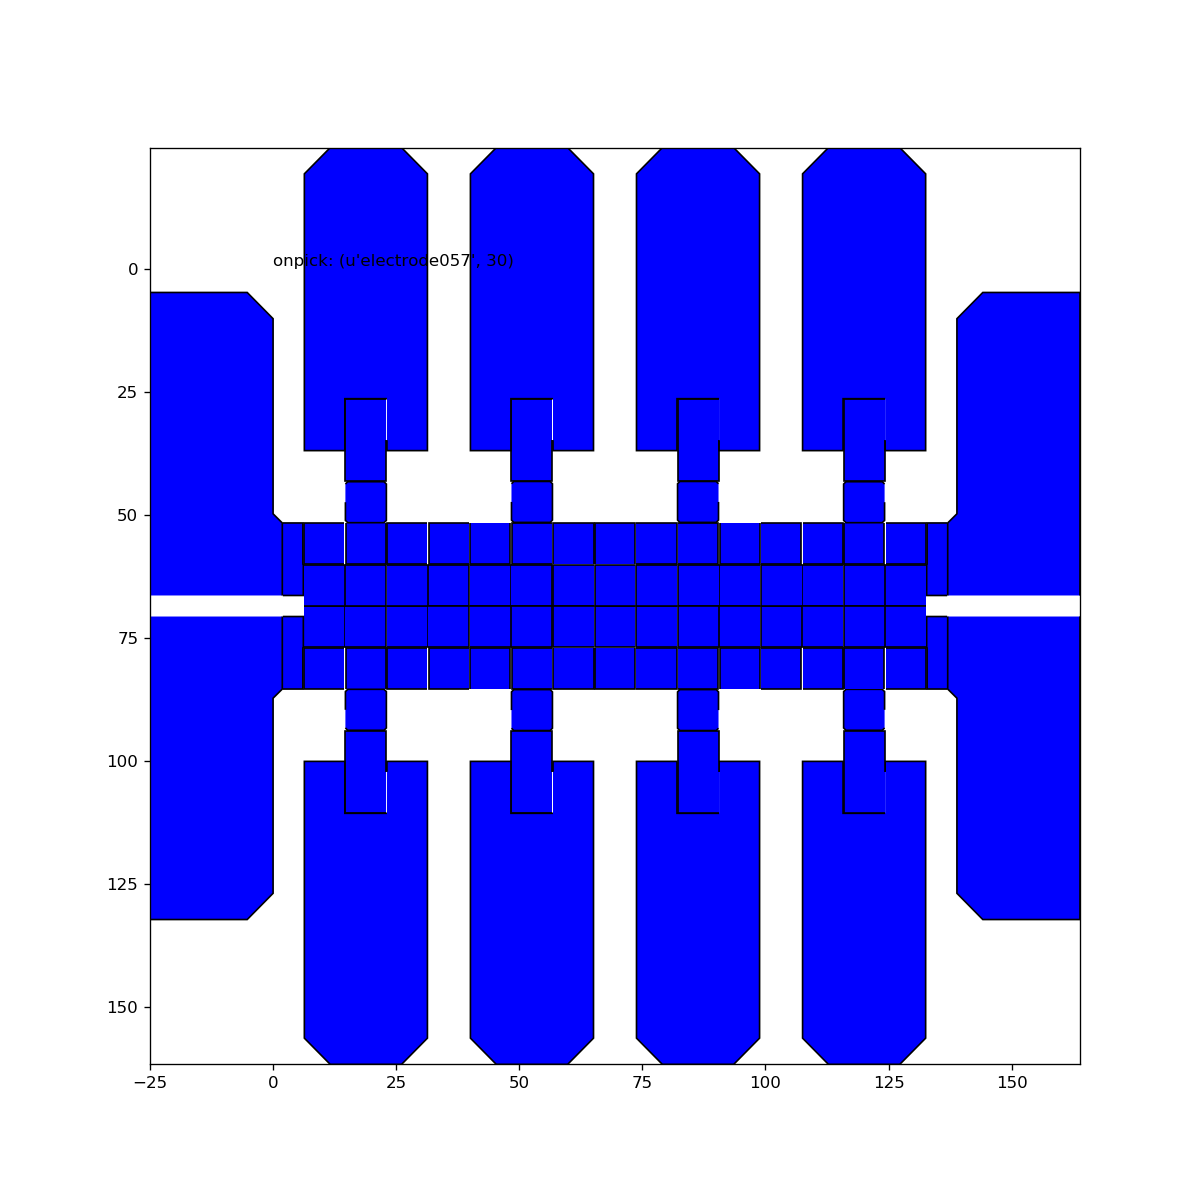

electrode058
electrode074


8

In [14]:
%matplotlib notebook
import blinker
import dropbot as db
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches
import matplotlib.collections
import svg_model


svg_path = db.DATA_DIR.joinpath('SCI-BOTS 90-pin array', 'device.svg')
df_shapes = svg_model.svg_shapes_to_df(svg_path)
electrode_channels = df_shapes.set_index('id').drop_duplicates(['data-channels'])['data-channels'].map(int)
channel_electrodes = pd.Series(electrode_channels.index, index=electrode_channels.values)
patches = [mpl.patches.Polygon(df_shape_i[['x', 'y']].values, closed=False, label=id_)
           for id_, df_shape_i in df_shapes.groupby('id')]

# fig, axes = plt.subplots(1, 2)

# ax = axes[0]
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_aspect(True)

state_of_channels = np.zeros(120, dtype='uint8')  # proxy.state_of_channels

for patch_i in patches:
    electrode_id = patch_i.get_label()
    if electrode_id in electrode_channels:
        electrode_state_i = state_of_channels[electrode_channels[electrode_id]]
    else:
        print(electrode_id)
        electrode_state_i = 0
    patch_i.set_facecolor('white' if electrode_state_i else 'blue')
    patch_i.set_edgecolor('black')
    ax.add_patch(patch_i)
    patch_i.set_picker(True)

ax.set_xlim(df_shapes.x.min(), df_shapes.x.max())
ax.set_ylim(df_shapes.y.max(), df_shapes.y.min())

# connection_id = fig.canvas.mpl_connect('button_press_event', onclick)
clicks = []
picks = []

signals = blinker.Namespace()
signals.signal('onclick').connect(clicks.append, weak=False)
signals.signal('onpick').connect(picks.append, weak=False)


def onclick(event):
    tx = ('onclick: button=%d, x=%d, y=%d, xdata=%f, ydata=%f' %
          (event.button, event.x, event.y, event.xdata, event.ydata))
    text.set_text(tx)
    signals.signal('onclick').send(event)

    
def on_pick(event):
    if event.mouseevent.button != 1:
        return
    signals.signal('onpick').send(event)
    electrode_id = event.artist.get_label()
    
    if electrode_id in electrode_channels:
        channel_i = electrode_channels[electrode_id]
        electrode_state_i = not state_of_channels[channel_i]
        state_of_channels[channel_i] = electrode_state_i 
    else:
        channel_i = None
        electrode_state_i = 0
    event.artist.set_facecolor('white' if electrode_state_i else 'blue')
    text.set_text('onpick: {}'.format((event.artist.get_label(), channel_i)))
#     proxy.state_of_channels = state_of_channels
    

text = ax.text(0,0, "", va="bottom", ha="left")
fig.canvas.mpl_connect('pick_event', on_pick)